# 라이브러리 불러오기

In [145]:
from glob import glob 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import folium
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 데이터 불러오기

In [106]:
glob('data/*.csv')

['data/test.csv', 'data/train.csv', 'data/sample_submission.csv']

In [107]:
train = pd.read_csv(glob('data/*.csv')[1])
test = pd.read_csv(glob('data/*.csv')[0])
submission = pd.read_csv(glob('data/*.csv')[2])

In [108]:
test = test.set_index('ID')
train = train.set_index('ID')
submission = submission.set_index('ID')

# 데이터 살펴보기

칼럼 설명
- ID : 샘플 별 고유 id
- Exercise_Duration  : 운동 시간(분)
- Body_Temperature(F) : 체온
- BPM : 심박수
- Height(Feet) : 키(피트)
- Height(Remainder_Inches) : 키(피트 계산 후 더해야 할 키)
- Weight(lb) : 몸무게(파운드)
- Weight_Status : 체중 상태
- Gender : 성별
- Age : 나이
- Calories_Burned : 칼로리 소모량(목표 예측값)

In [109]:
train.head()

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
ID,,,,,,,,,,
TRAIN_0000,26.0,105.6,107.0,5.0,9.0,154.3,Normal Weight,F,45,166.0
TRAIN_0001,7.0,103.3,88.0,6.0,6.0,224.9,Overweight,M,50,33.0
TRAIN_0002,7.0,103.3,86.0,6.0,3.0,218.3,Overweight,M,29,23.0
TRAIN_0003,17.0,104.0,99.0,5.0,6.0,147.7,Normal Weight,F,33,91.0
TRAIN_0004,9.0,102.7,88.0,5.0,10.0,169.8,Normal Weight,M,38,32.0


## 결측치 확인

In [110]:
# 결측치 없음 
train.isnull().sum()

Exercise_Duration           0
Body_Temperature(F)         0
BPM                         0
Height(Feet)                0
Height(Remainder_Inches)    0
Weight(lb)                  0
Weight_Status               0
Gender                      0
Age                         0
Calories_Burned             0
dtype: int64

In [111]:
# 결측치 없음 
test.isnull().sum()

Exercise_Duration           0
Body_Temperature(F)         0
BPM                         0
Height(Feet)                0
Height(Remainder_Inches)    0
Weight(lb)                  0
Weight_Status               0
Gender                      0
Age                         0
dtype: int64

## 이상치 확인

In [112]:
train.describe()

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Age,Calories_Burned
count,7500.0000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,15.5012,104.033573,95.498133,5.248800,5.717600,165.361187,42.636000,89.373467
std,8.3553,1.412845,9.587331,0.556663,3.497315,33.308136,16.883188,62.817086
min,1.0000,98.800000,69.000000,4.000000,0.000000,79.400000,20.000000,1.000000
25%,8.0000,103.300000,88.000000,5.000000,3.000000,138.900000,28.000000,35.000000
50%,15.0000,104.400000,95.000000,5.000000,6.000000,163.100000,39.000000,77.000000
75%,23.0000,105.100000,103.000000,6.000000,9.000000,191.800000,56.000000,138.000000
max,30.0000,106.700000,128.000000,7.000000,12.000000,291.000000,79.000000,300.000000


In [113]:
train.describe(include='O')

,Weight_Status,Gender
count,7500,7500
unique,3,2
top,Normal Weight,F
freq,4681,3769


<Axes: >

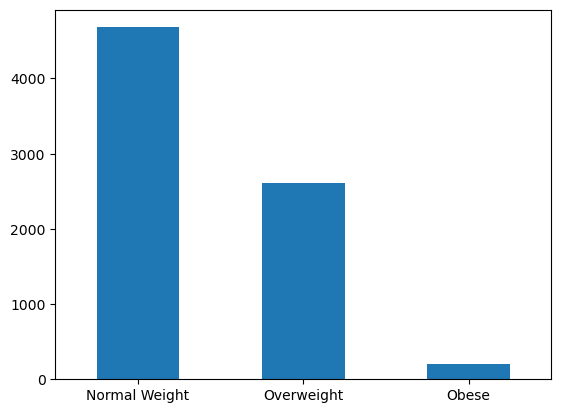

In [114]:
# Obese가 현저히 적음
train['Weight_Status'].value_counts().plot.bar(rot=0)

In [115]:
train['Weight_Status'].value_counts(1)

Normal Weight    0.624133
Overweight       0.348533
Obese            0.027333
Name: Weight_Status, dtype: float64

<Axes: >

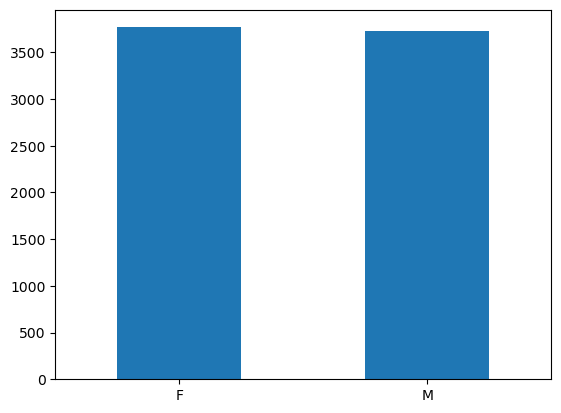

In [116]:
train['Gender'].value_counts().plot.bar(rot=0)

# 피처 엔지니어링

In [117]:
train.head(2)

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
ID,,,,,,,,,,
TRAIN_0000,26.0,105.6,107.0,5.0,9.0,154.3,Normal Weight,F,45,166.0
TRAIN_0001,7.0,103.3,88.0,6.0,6.0,224.9,Overweight,M,50,33.0


- 두 키 변수를 합해서 하나의 변수로 만들어 준다. 

In [118]:
# ft, inch column을 하나의 cm 컬럼으로 변경해줌 
train['Height(cm)'] = train['Height(Feet)'] * 30.48 + train['Height(Remainder_Inches)']*2.54
test['Height(cm)'] = test['Height(Feet)'] * 30.48 + test['Height(Remainder_Inches)']*2.54

In [119]:
# 기존 ft, inch column은 삭제 
train = train.drop(columns=['Height(Feet)','Height(Remainder_Inches)'])
test = test.drop(columns=['Height(Feet)','Height(Remainder_Inches)'])

- 몸무게와 몸의 온도를 kg, 섭씨로 바꿔준다. 

In [120]:
train['Weight(kg)'] = train['Weight(lb)'] * 0.45359237
test['Weight(kg)'] = test['Weight(lb)'] * 0.45359237

train['Body_Temperature(C)'] = (train['Body_Temperature(F)'] - 32)*(5/9)
test['Body_Temperature(C)'] = (test['Body_Temperature(F)'] - 32)*(5/9)

# drop
train = train.drop(columns=['Weight(lb)','Body_Temperature(F)'])
test = test.drop(columns=['Weight(lb)','Body_Temperature(F)'])

In [121]:
train

,Exercise_Duration,BPM,Weight_Status,Gender,Age,Calories_Burned,Height(cm),Weight(kg),Body_Temperature(C)
ID,,,,,,,,,
TRAIN_0000,26.0,107.0,Normal Weight,F,45,166.0,175.26,69.989303,40.888889
TRAIN_0001,7.0,88.0,Overweight,M,50,33.0,198.12,102.012924,39.611111
TRAIN_0002,7.0,86.0,Overweight,M,29,23.0,190.50,99.019214,39.611111
TRAIN_0003,17.0,99.0,Normal Weight,F,33,91.0,167.64,66.995593,40.000000
TRAIN_0004,9.0,88.0,Normal Weight,M,38,32.0,177.80,77.019984,39.277778
...,...,...,...,...,...,...,...,...,...
TRAIN_7495,22.0,104.0,Normal Weight,F,75,151.0,147.32,50.983782,40.611111
TRAIN_7496,20.0,104.0,Normal Weight,F,21,114.0,172.72,66.995593,40.722222
TRAIN_7497,8.0,90.0,Overweight,M,57,41.0,187.96,91.988533,39.500000


- 2가지 categorical value인 Gender와 Weight_status를 인코딩 해준다. 
- Gender는 비율이 50대 50이므로 label encoding 
- Weight_status 비율이 고르지 못하므로 One-Hot Encoding을 적용한다. 

In [122]:
# Label Encoding 
# Train 데이터 
train.loc[train['Gender'] == 'F', 'Gender'] = 0
train.loc[train['Gender'] == 'M', 'Gender'] = 1

# Test 데이터 
test.loc[test['Gender'] == 'F', 'Gender'] = 0
test.loc[test['Gender'] == 'M', 'Gender'] = 1

In [123]:
# dtype 변경해 주기 
train['Gender'] = train['Gender'].astype('int')
test['Gender'] = test['Gender'].astype('int')

In [124]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, TRAIN_0000 to TRAIN_7499
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Exercise_Duration            7500 non-null   float64
 1   BPM                          7500 non-null   float64
 2   Gender                       7500 non-null   int64  
 3   Age                          7500 non-null   int64  
 4   Calories_Burned              7500 non-null   float64
 5   Height(cm)                   7500 non-null   float64
 6   Weight(kg)                   7500 non-null   float64
 7   Body_Temperature(C)          7500 non-null   float64
 8   Weight_Status_Normal Weight  7500 non-null   uint8  
 9   Weight_Status_Obese          7500 non-null   uint8  
 10  Weight_Status_Overweight     7500 non-null   uint8  
dtypes: float64(6), int64(2), uint8(3)
memory usage: 549.3+ KB


In [126]:
test.head(2)

,Exercise_Duration,BPM,Gender,Age,Height(cm),Weight(kg),Body_Temperature(C),Weight_Status_Normal Weight,Weight_Status_Obese,Weight_Status_Overweight
ID,,,,,,,,,,
TEST_0000,26.0,107.0,0,45,154.94,51.981686,40.611111,1,0,0
TEST_0001,29.0,111.0,1,21,187.96,89.992726,40.500000,0,0,1


# 데이터 시각화

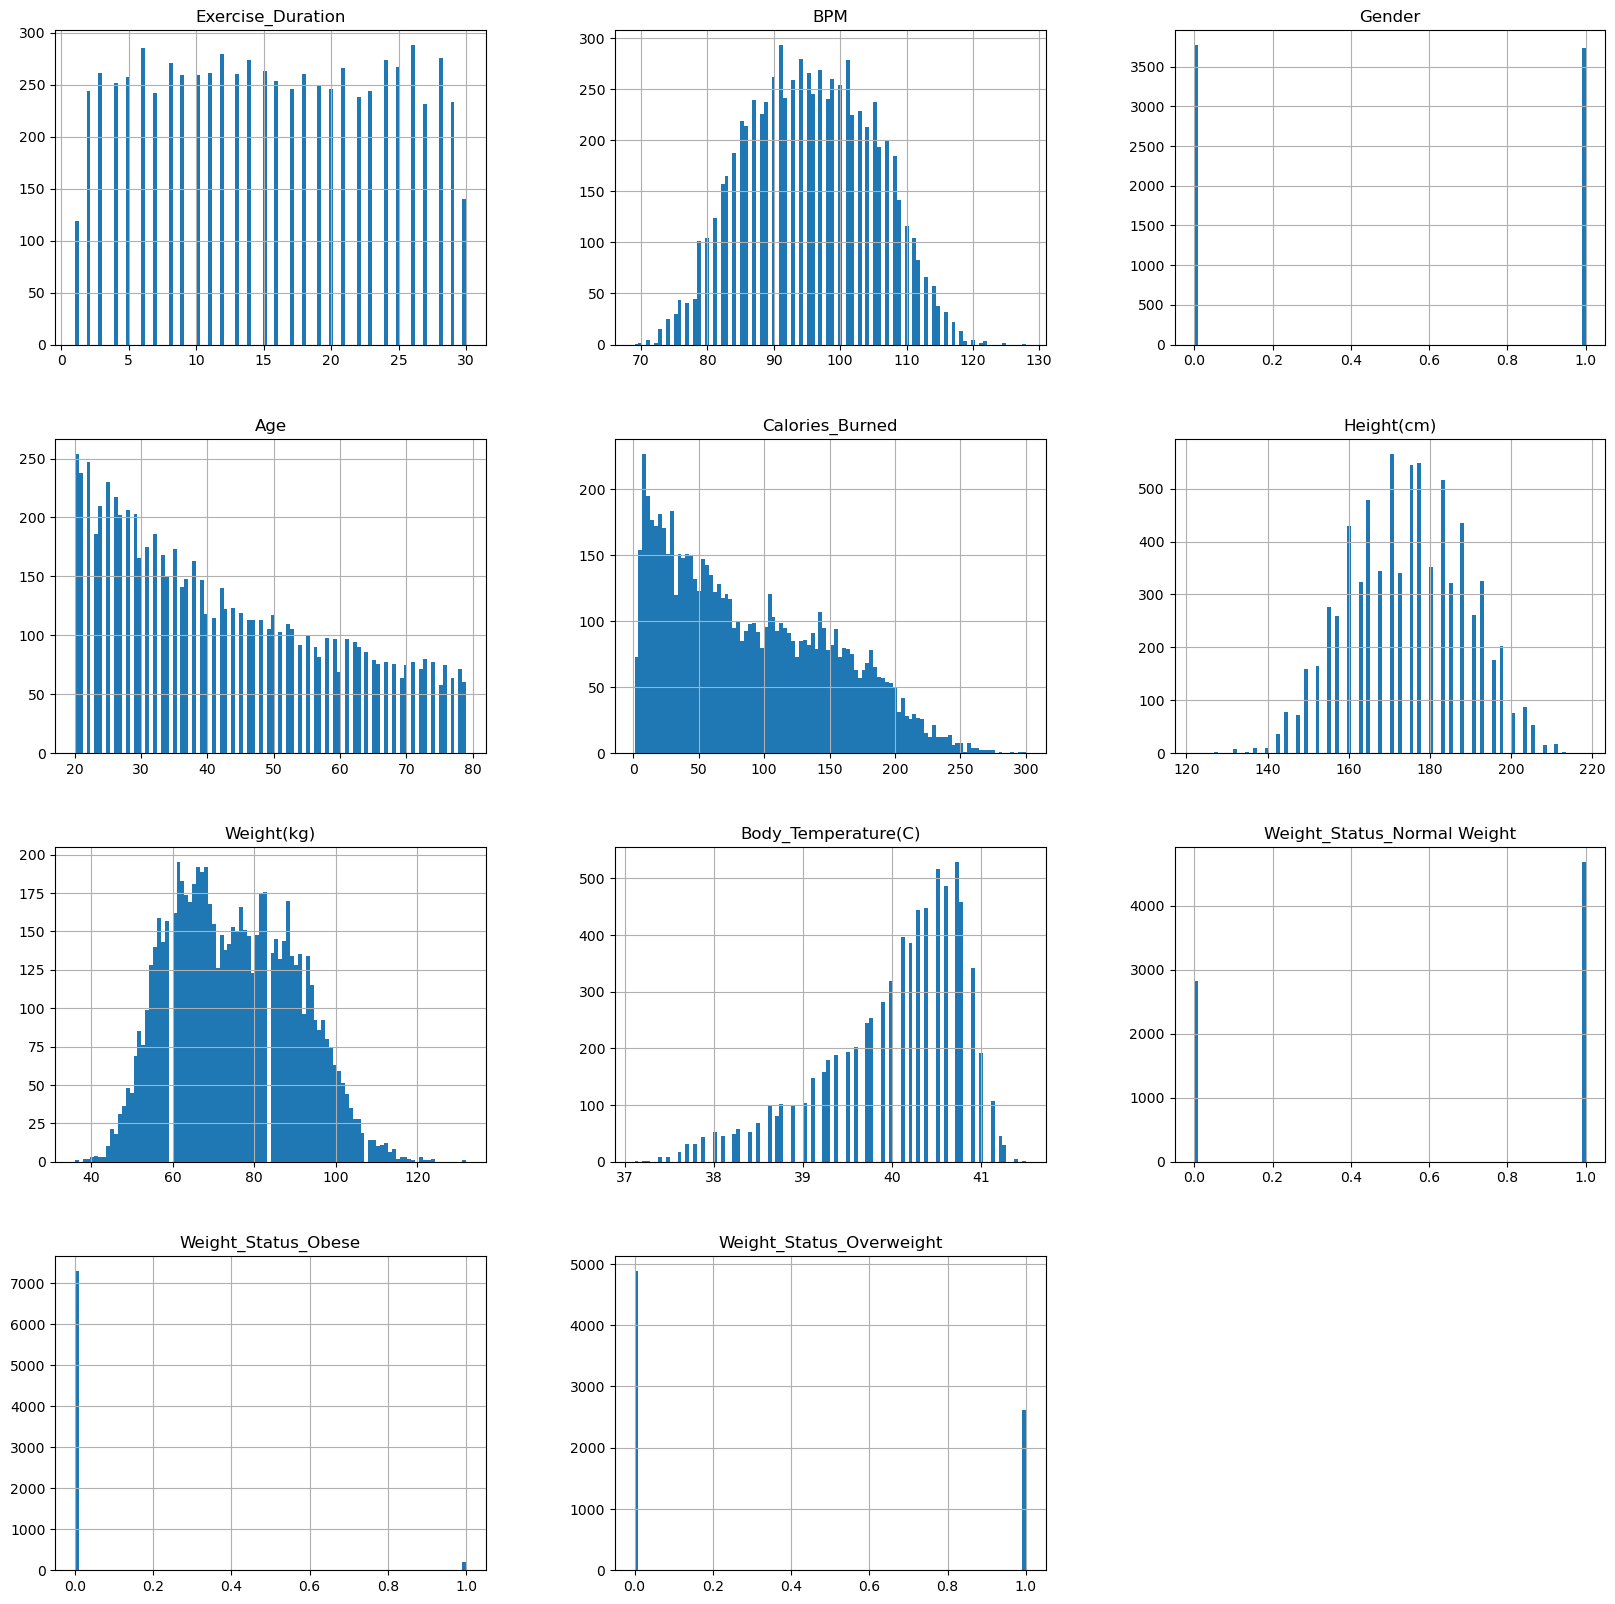

In [127]:
train.hist(bins=100,figsize=(20,20));

In [128]:
train['Body_Temperature(C)'].describe()

count    7500.000000
mean       40.018652
std         0.784914
min        37.111111
25%        39.611111
50%        40.222222
75%        40.611111
max        41.500000
Name: Body_Temperature(C), dtype: float64

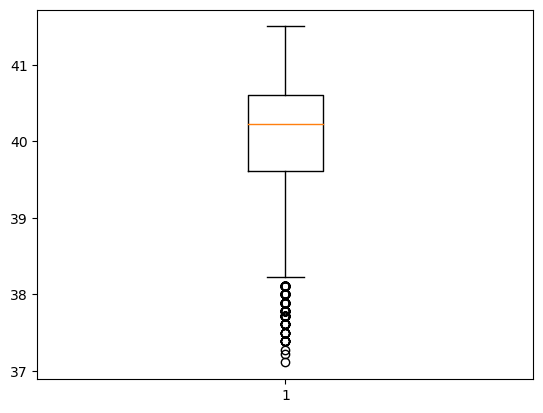

In [129]:
# 몇 개의 낮은 온도의 Outlier가 보입니다. 
plt.boxplot(train['Body_Temperature(C)']);

In [130]:
train['BPM'].describe()

count    7500.000000
mean       95.498133
std         9.587331
min        69.000000
25%        88.000000
50%        95.000000
75%       103.000000
max       128.000000
Name: BPM, dtype: float64

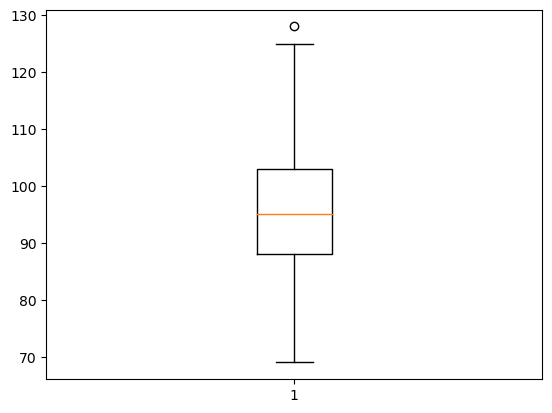

In [131]:
# 심박도 Outlier가 하나 있습니다. 
plt.boxplot(train['BPM']);

In [132]:
train['Weight(kg)'].describe()

count    7500.000000
mean       75.006573
std        15.108316
min        36.015234
25%        63.003980
50%        73.980916
75%        86.999017
max       131.995380
Name: Weight(kg), dtype: float64

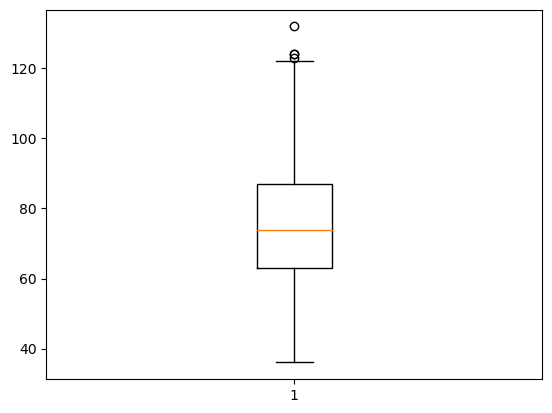

In [133]:
# 몇 개의 몸무게 outlier가 있습니다. 
plt.boxplot(train['Weight(kg)']);

In [134]:
train.describe()

,Exercise_Duration,BPM,Gender,Age,Calories_Burned,Height(cm),Weight(kg),Body_Temperature(C),Weight_Status_Normal Weight,Weight_Status_Obese,Weight_Status_Overweight
count,7500.0000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,15.5012,95.498133,0.497467,42.636000,89.373467,174.506128,75.006573,40.018652,0.624133,0.027333,0.348533
std,8.3553,9.587331,0.500027,16.883188,62.817086,14.318365,15.108316,0.784914,0.484378,0.163064,0.476538
min,1.0000,69.000000,0.000000,20.000000,1.000000,121.920000,36.015234,37.111111,0.000000,0.000000,0.000000
25%,8.0000,88.000000,0.000000,28.000000,35.000000,165.100000,63.003980,39.611111,0.000000,0.000000,0.000000
50%,15.0000,95.000000,0.000000,39.000000,77.000000,175.260000,73.980916,40.222222,1.000000,0.000000,0.000000
75%,23.0000,103.000000,1.000000,56.000000,138.000000,185.420000,86.999017,40.611111,1.000000,0.000000,1.000000
max,30.0000,128.000000,1.000000,79.000000,300.000000,218.440000,131.995380,41.500000,1.000000,1.000000,1.000000


- bmi 공식 : BMI = kg/m2
- overweight은 BMI 25~30 사이 
- obese는 그 이상 

In [135]:
q1 = np.percentile(train['Weight(kg)'], 25)
q3 = np.percentile(train['Weight(kg)'], 75)
iqr = q3 - q1
weight_check = train.loc[train['Weight(kg)'] > q3 + iqr * 1.5,:].copy()
weight_check

,Exercise_Duration,BPM,Gender,Age,Calories_Burned,Height(cm),Weight(kg),Body_Temperature(C),Weight_Status_Normal Weight,Weight_Status_Obese,Weight_Status_Overweight
ID,,,,,,,,,,,
TRAIN_1672,16.0,87.0,1,67,94.0,210.82,124.012154,40.111111,0,0,1
TRAIN_2227,1.0,88.0,1,40,5.0,218.44,131.995380,37.777778,0,0,1
TRAIN_2457,17.0,103.0,1,43,121.0,213.36,124.012154,40.722222,0,0,1
TRAIN_4889,25.0,103.0,1,74,215.0,210.82,123.014251,40.777778,0,0,1


In [136]:
# overweight 맞음. 키가 많이 커서 몸무게가 많이 나가도 상관 x 
weight_check['Weight(kg)']/np.square((weight_check['Height(cm)']/100))

ID
TRAIN_1672    27.902340
TRAIN_2227    27.662689
TRAIN_2457    27.241953
TRAIN_4889    27.677815
dtype: float64

# 다중공선성 확인

In [137]:
train.head(2)

,Exercise_Duration,BPM,Gender,Age,Calories_Burned,Height(cm),Weight(kg),Body_Temperature(C),Weight_Status_Normal Weight,Weight_Status_Obese,Weight_Status_Overweight
ID,,,,,,,,,,,
TRAIN_0000,26.0,107.0,0,45,166.0,175.26,69.989303,40.888889,1,0,0
TRAIN_0001,7.0,88.0,1,50,33.0,198.12,102.012924,39.611111,0,0,1


In [138]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 종속 변수와 독립 변수 분리
X = train.drop(columns='Calories_Burned')

# VIF 계산

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

print(vif)

    VIF Factor                     features
0     8.210682            Exercise_Duration
1     3.685165                          BPM
2     2.830266                       Gender
3     1.119195                          Age
4    23.479034                   Height(cm)
5    32.721601                   Weight(kg)
6     5.489530          Body_Temperature(C)
7  9227.882142  Weight_Status_Normal Weight
8   403.230304          Weight_Status_Obese
9  5107.626376     Weight_Status_Overweight


## 전체 분포 확인

<Axes: >

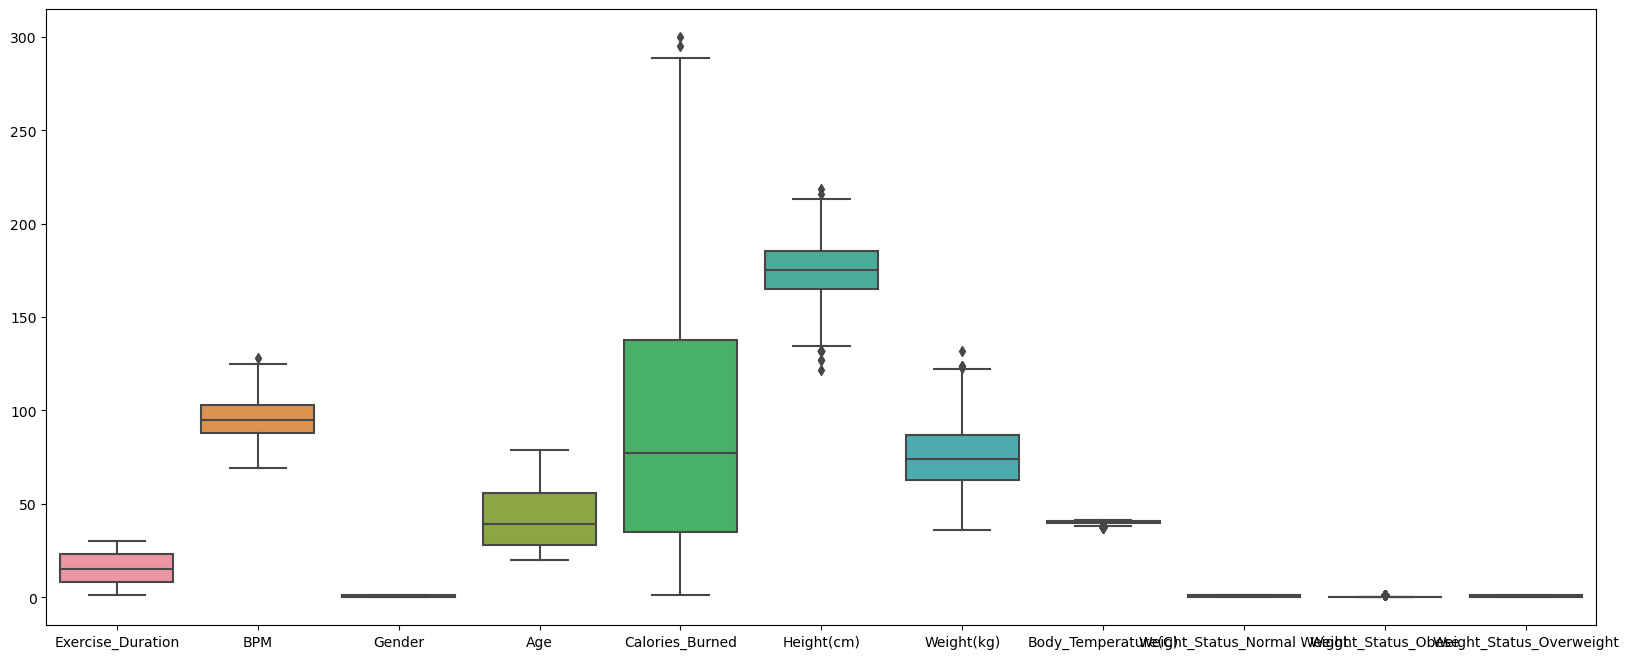

In [139]:
# 인코딩을 한 값을 제외하면 분포가 고르지 않은 걸 확인할 수 있다. 
plt.figure(figsize=(20,8))
sns.boxplot(train)

## 상관계수 분석

In [142]:
# 인코딩된 컬럼을 제외하고 상관계수 분석 
correlation = train[['Exercise_Duration', 'BPM', 'Age','Height(cm)',
                     'Weight(kg)', 'Body_Temperature(C)', 'Calories_Burned']].corr()

<Axes: >

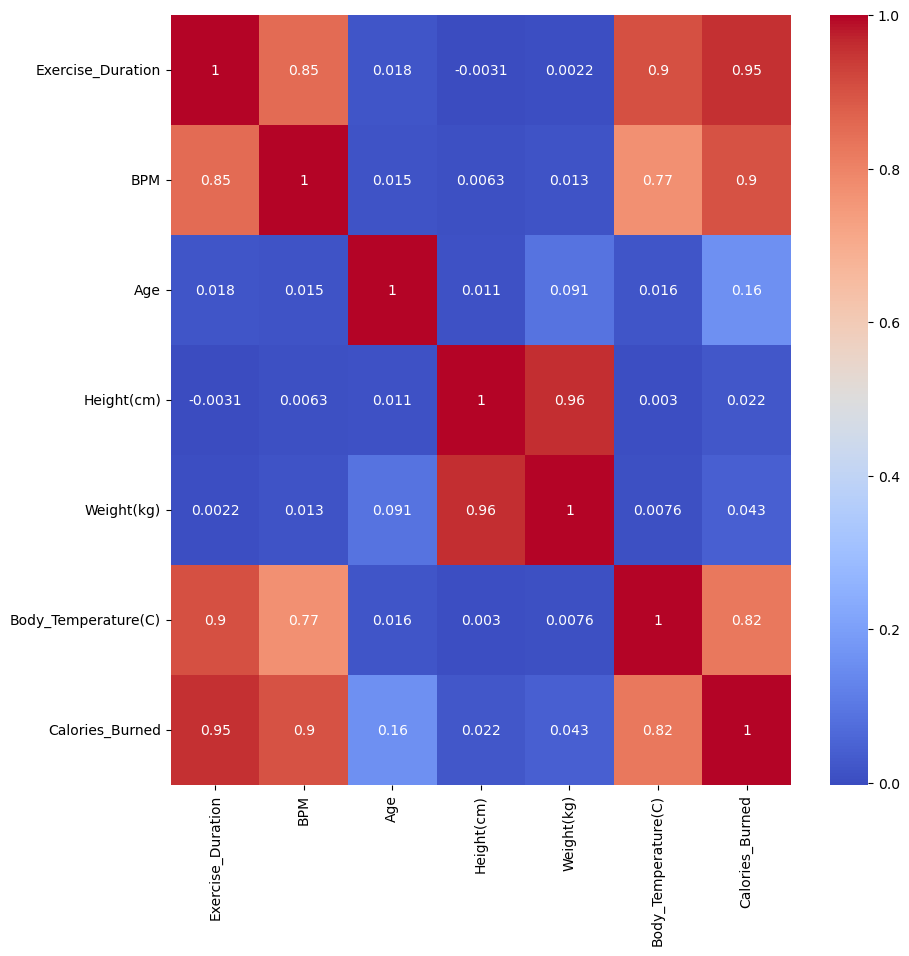

In [143]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

## 머신러닝 - Lasso

In [154]:
X = train.drop(columns=['Calories_Burned'])
y = train['Calories_Burned']

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [156]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}

In [157]:
lasso_model = Lasso()

In [158]:
grid_search = GridSearchCV(lasso_model, param_grid, cv=5)  # Use 5-fold cross-validation
grid_search.fit(X_train, y_train)  # Fit the grid search on the training data

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]})

In [159]:
best_alpha = grid_search.best_params_['alpha']  # Get the best value for alpha
best_model = grid_search.best_estimator_ 

In [160]:
y_pred = best_model.predict(X_test)

In [162]:
mse = mean_squared_error(y_test, y_pred)
print("Best Alpha:", best_alpha)
print("Best Model Coefficients:", best_model.coef_)
print("Best Model Intercept:", best_model.intercept_)
print("Mean Squared Error:", mse)

Best Alpha: 0.01
Best Model Coefficients: [  6.58248441   2.04574777  -1.4892199    0.50460565  -0.13769081
   0.25610267 -16.84906636  -0.          -0.           0.81942154]
Best Model Intercept: 449.9938293591757
Mean Squared Error: 119.64781003220783


In [163]:
y_pred = best_model.fit(X,y).predict(test)

In [165]:
submission['Calories_Burned'] = y_pred

In [166]:
submission.to_csv('The_Calories_EDA3차_ML_Lasso.csv')